In [1]:
import napari
from napari.utils import nbscreenshot
import numpy as np
import pandas as pd
import scanpy as sc

from morphometrics.data import cylinders_and_spheres
from morphometrics.explore.cluster import cluster_features
from morphometrics.explore.dimensionality_reduction import pca, umap
from morphometrics.measure import measure_selected
from morphometrics.utils.anndata_utils import table_to_anndata

rng = np.random.default_rng(42)

/Users/kyamauch/Documents/morphometrics/src/morphometrics/measure/label.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# load the sample images
label_image, label_table, intensity_image = cylinders_and_spheres()

In [14]:
# add the sample images to the viewer
viewer = napari.view_labels(label_image, features=label_table)
viewer.add_image(intensity_image, visible=False)

<Image layer 'intensity_image' at 0x7fa8f05769d0>

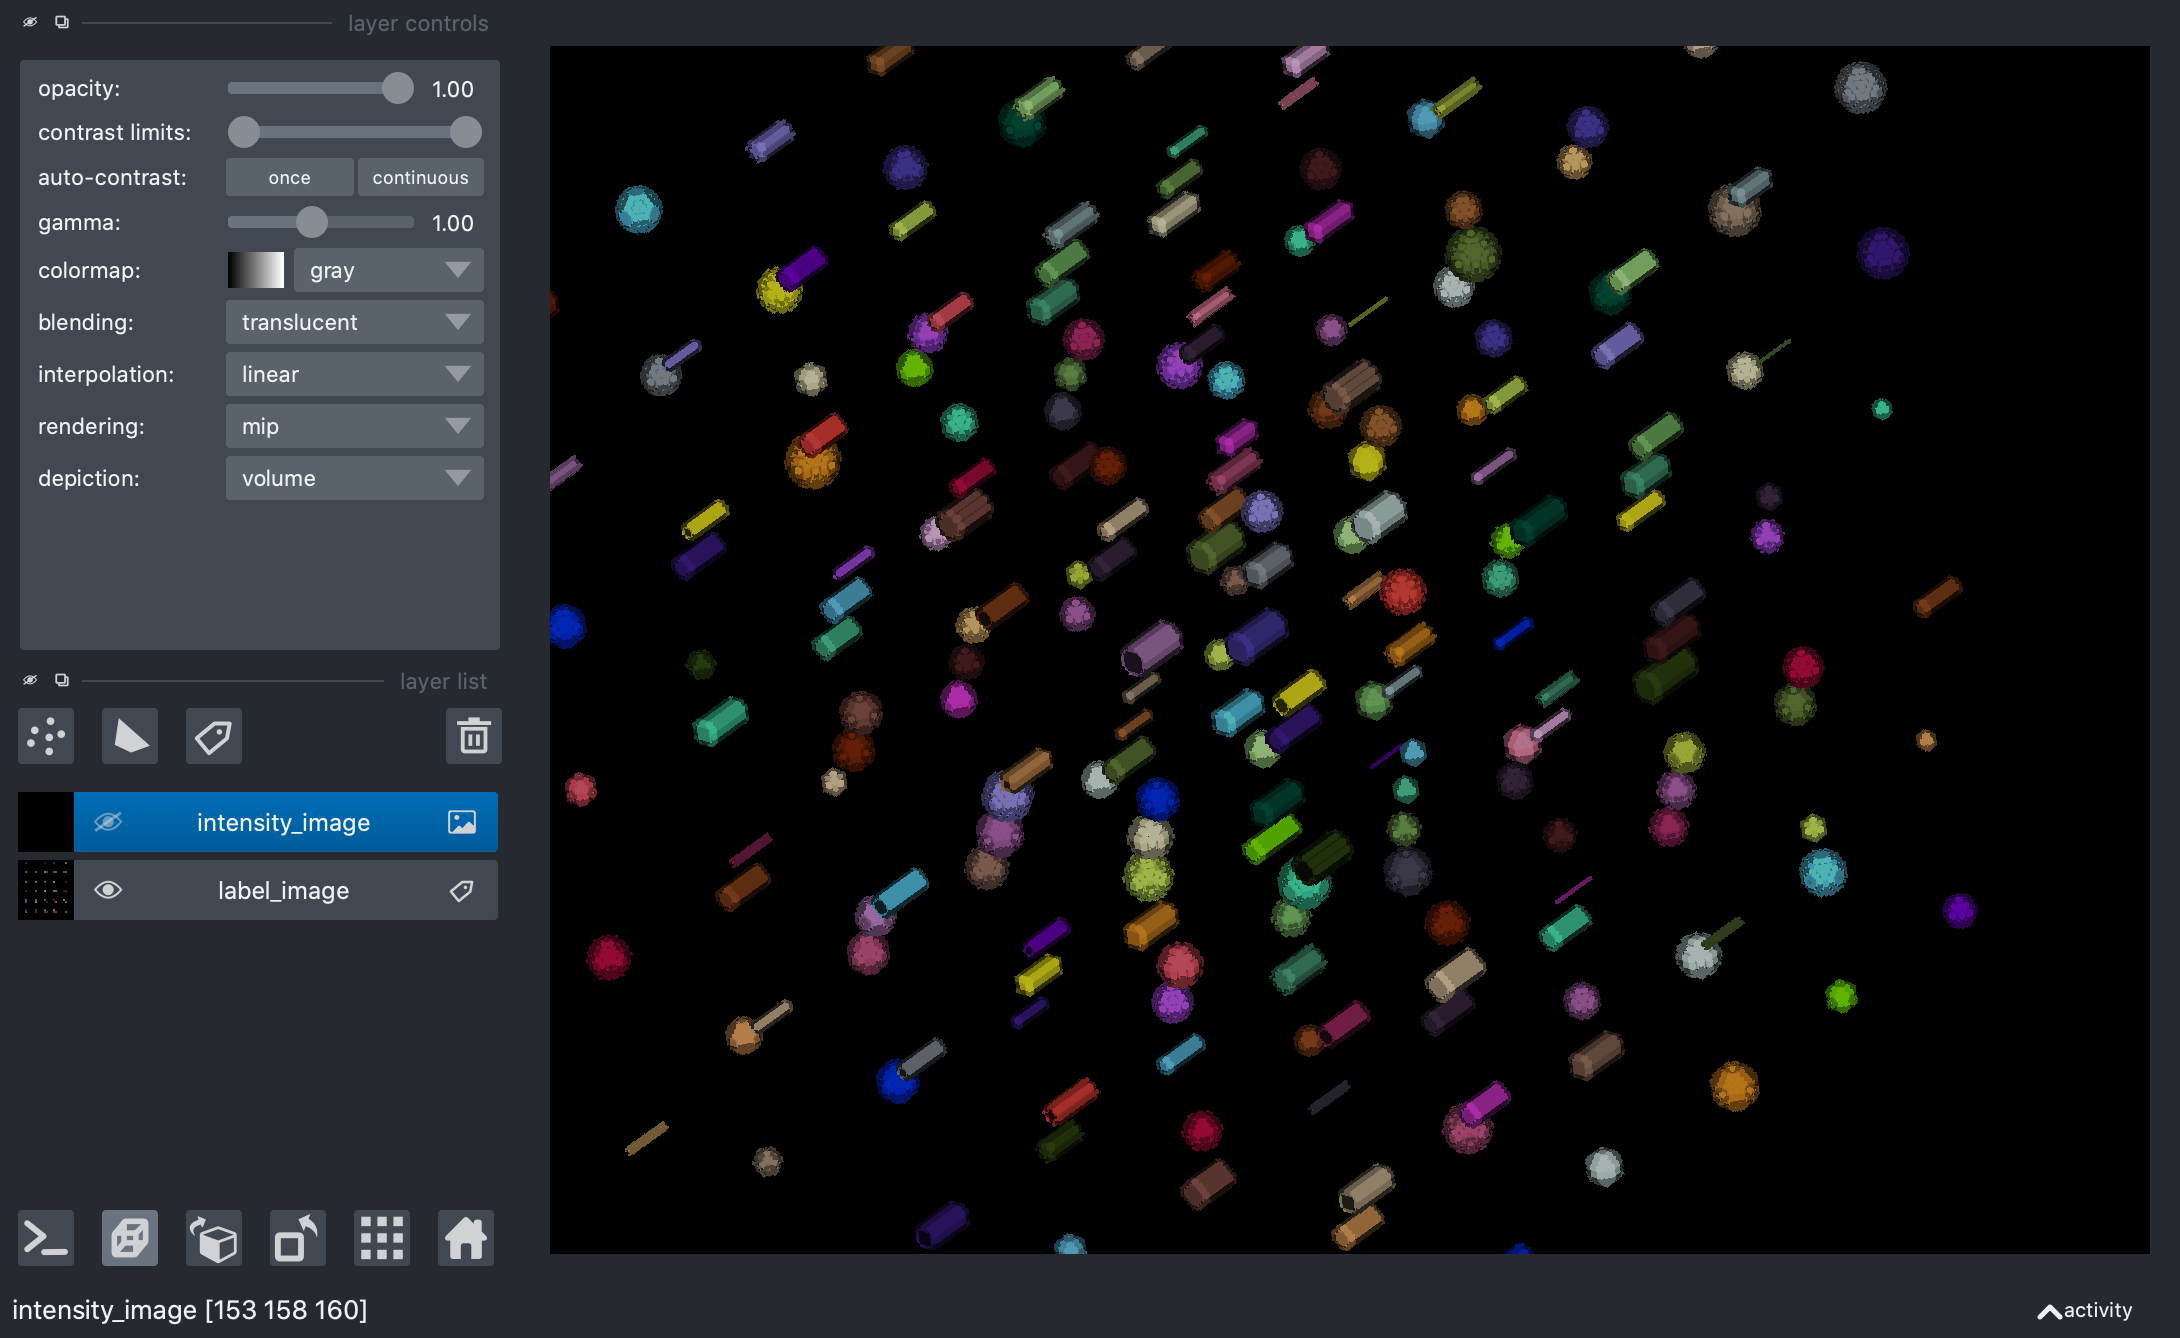

In [4]:
viewer.dims.ndisplay = 3

nbscreenshot(viewer)

In [5]:
# make the measurements

measurement_selection = [
    "surface_properties_from_labels",
    {
        "name": "regionprops",
        "choices": {
             "size": False,
            "intensity": True,
            "position": False,
            "moments": False
        },
    },
]

all_measurements = measure_selected(
    label_image=label_image,
    intensity_image=intensity_image,
    measurement_selection=measurement_selection,
)

all_measurements.head()

  0%|          | 0/217 [00:00<?, ?it/s]

,surface_area,curvature_mean,curvature_stdev,curvature_0,curvature_10,curvature_20,curvature_30,curvature_40,curvature_50,curvature_60,curvature_70,curvature_80,curvature_90,curvature_100,max_intensity,mean_intensity,min_intensity,standard_deviation_intensity
label,,,,,,,,,,,,,,,,,,
1,431.539821,-14.174583,2.718100,-28.160018,-16.311390,-15.543505,-15.100626,-14.588082,-14.236206,-13.859509,-13.351810,-12.231456,-10.457056,-8.447891,0.798684,0.798684,0.798684,1.110223e-16
2,515.625191,-12.230682,0.642772,-13.774117,-13.110218,-12.908614,-12.688435,-12.311259,-12.118124,-11.842123,-11.736034,-11.668173,-11.582039,-11.221591,0.348350,0.348350,0.348350,5.551115e-17
3,349.871722,-16.370577,2.782248,-25.453676,-19.075474,-17.519248,-17.218528,-17.026573,-16.678844,-15.879726,-15.689523,-13.802004,-12.637379,-10.864902,0.612372,0.612372,0.612372,0.000000e+00
4,349.507141,-16.673350,2.888261,-24.784948,-19.767262,-18.742127,-18.287274,-17.870555,-16.552620,-16.280190,-15.698353,-13.738252,-13.006505,-11.398300,0.663971,0.663971,0.663971,2.220446e-16
5,495.691402,-12.417467,0.269589,-13.028942,-12.689400,-12.654743,-12.530923,-12.455418,-12.443071,-12.392187,-12.294498,-12.236039,-12.087494,-11.658909,0.704837,0.704837,0.704837,0.000000e+00


In [6]:
# convert the measurement table to an AnnData object
measurement_data = table_to_anndata(
    measurement_table=all_measurements,
    obs=label_table
)

print(measurement_data)

AnnData object with n_obs × n_vars = 216 × 18
    obs: 'label', 'shape'


/Users/kyamauch/opt/miniconda3/envs/morphometrics/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


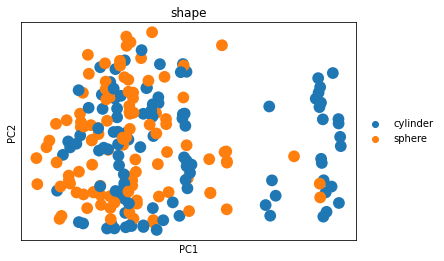

In [7]:
# Use PCA to reduce dimensionality
%matplotlib inline

pca(measurement_data, normalize_data=True)
sc.pl.pca(measurement_data, color=['shape'])

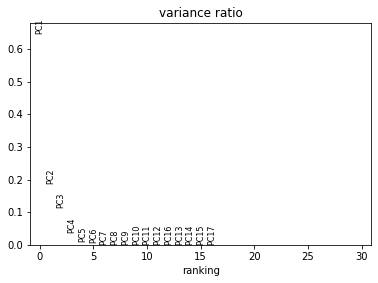

In [8]:
# plot the variation per priniciple component to determine
# how many principle components we need to build the neighbor
# graph
sc.pl.pca_variance_ratio(measurement_data)

OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


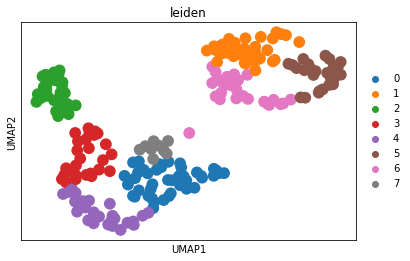

In [9]:
# Build the neighbor graph and calculate UMAP
cluster_features(
    measurement_data,
    method="leiden",
    compute_neighbors=True,
    neighbors_kwargs={"n_pcs": 6}
)

umap(measurement_data, compute_neighbors=False)
sc.pl.umap(measurement_data, color='leiden')

In [15]:
# add the measurement_data to the viewer layer so it can be accessed by the plugin
viewer.layers["label_image"].metadata = {"adata": measurement_data}


## Setup annotation
1. Open the plugin from the plugins menu: Plugins -> morphometrics -> Annotate clustered features
2. Select the label layer to annotate by choosing `label_image` from the "labels layer" dropdown menu.
3. Update the annotation classes to "cylinder" and "sphere".
    1. Delete extra classes by clicking on the label and then clicking the "-" button.
    1. Rename classes by click on them and typing a new name.
1. Set the "groupby" to "leiden". This will ensure that we sample the same number of samples from each cluster
1. Set the number of samples per group to 4. This means that we will anotate four random samples from each cluster.
1. Ensure the "random seed" is set for reproducibility. This ensures that the same samples will be repeated each time.
1. Click "start annotating" when you are ready to begin.

![setup annotation](./images/setup_annotation.png)

## Annotate objects
1. Select the "label_image" from the layer list.
1. Click "show selected" in the layer controls to only view the object to be annotated.
1. View the object and determine which class it belongs to (i.e., cylinder or sphere). Either click the corresponding button or use the listed hotkey to annotate it. The next sample will automatically be displayed.
1. Annotate all of the sampled objects. The percentage of the sampled objects you have annotated is displayed in a progress bar.

![annotation workflow](./images/annotation_workflow.png)

## End annotation
To end annotation, click the "stop annotating" button.

In [ ]:
## retrieve the measurements back from the viewer
annotated_measurements = viewer.layers["label_image"].metadata["adata"]

# get the rows that have been annotated
obs = annotated_measurements.obs
annotated_row_mask = obs["label_value"].notna()
annotated_rows = annotated_measurements[annotated_row_mask, :].copy()


In [20]:
# encode the shape as 0=cylinder and sphere=1 so we can train
# a random forest classifier to predict shape from the
# measured features

annotated_obs = annotated_rows.obs
annotated_obs['shape_label'] = annotated_obs['label_value'].map({'cylinder': 0, 'sphere': 1})

In [21]:
from sklearn.ensemble import RandomForestClassifier

# get the measurements (X) and labels (y) for training the random forest classifier
X = annotated_rows.X
y = annotated_obs['shape_label'].to_numpy()

# train the random forest classifier
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X, y)

RandomForestClassifier()

In [22]:
# to test, will predict on the full measurement table
X_full = measurement_data.X

# test the classifier performance on the test data set
y_pred = clf.predict(X_full)


In [23]:
from sklearn import metrics

# the ground truth is in the "shape" column. As before, we will encode
# cylinder as 0 and sphere as 1
full_obs = measurement_data.obs
full_obs['shape_label'] = full_obs['shape'].map({'cylinder': 0, 'sphere': 1})
y_ground_truth = full_obs['shape_label'].to_numpy()

# use sklearn to calcuate the accuracy
accuracy = metrics.accuracy_score(y_ground_truth, y_pred)
percent_annotated = int(len(annotated_rows) / len(measurement_data) * 100)
print(f"Accuracy: {accuracy:.2f} with {percent_annotated}% annotation")

Accuracy: 0.99 with 14% annotation


In [24]:
# display predictions in napari viewer

y_pred_all = clf.predict(X_full)

prediction_image = np.zeros_like(label_image)

for shape_prediction, label_index in zip(y_pred_all, full_obs['label']):
    prediction_image[label_image == label_index] = shape_prediction + 1

viewer.add_labels(prediction_image, color={1: [0, 1, 0, 1], 2: [1, 0, 1, 1]})

<Labels layer 'prediction_image' at 0x7fa883c89fa0>

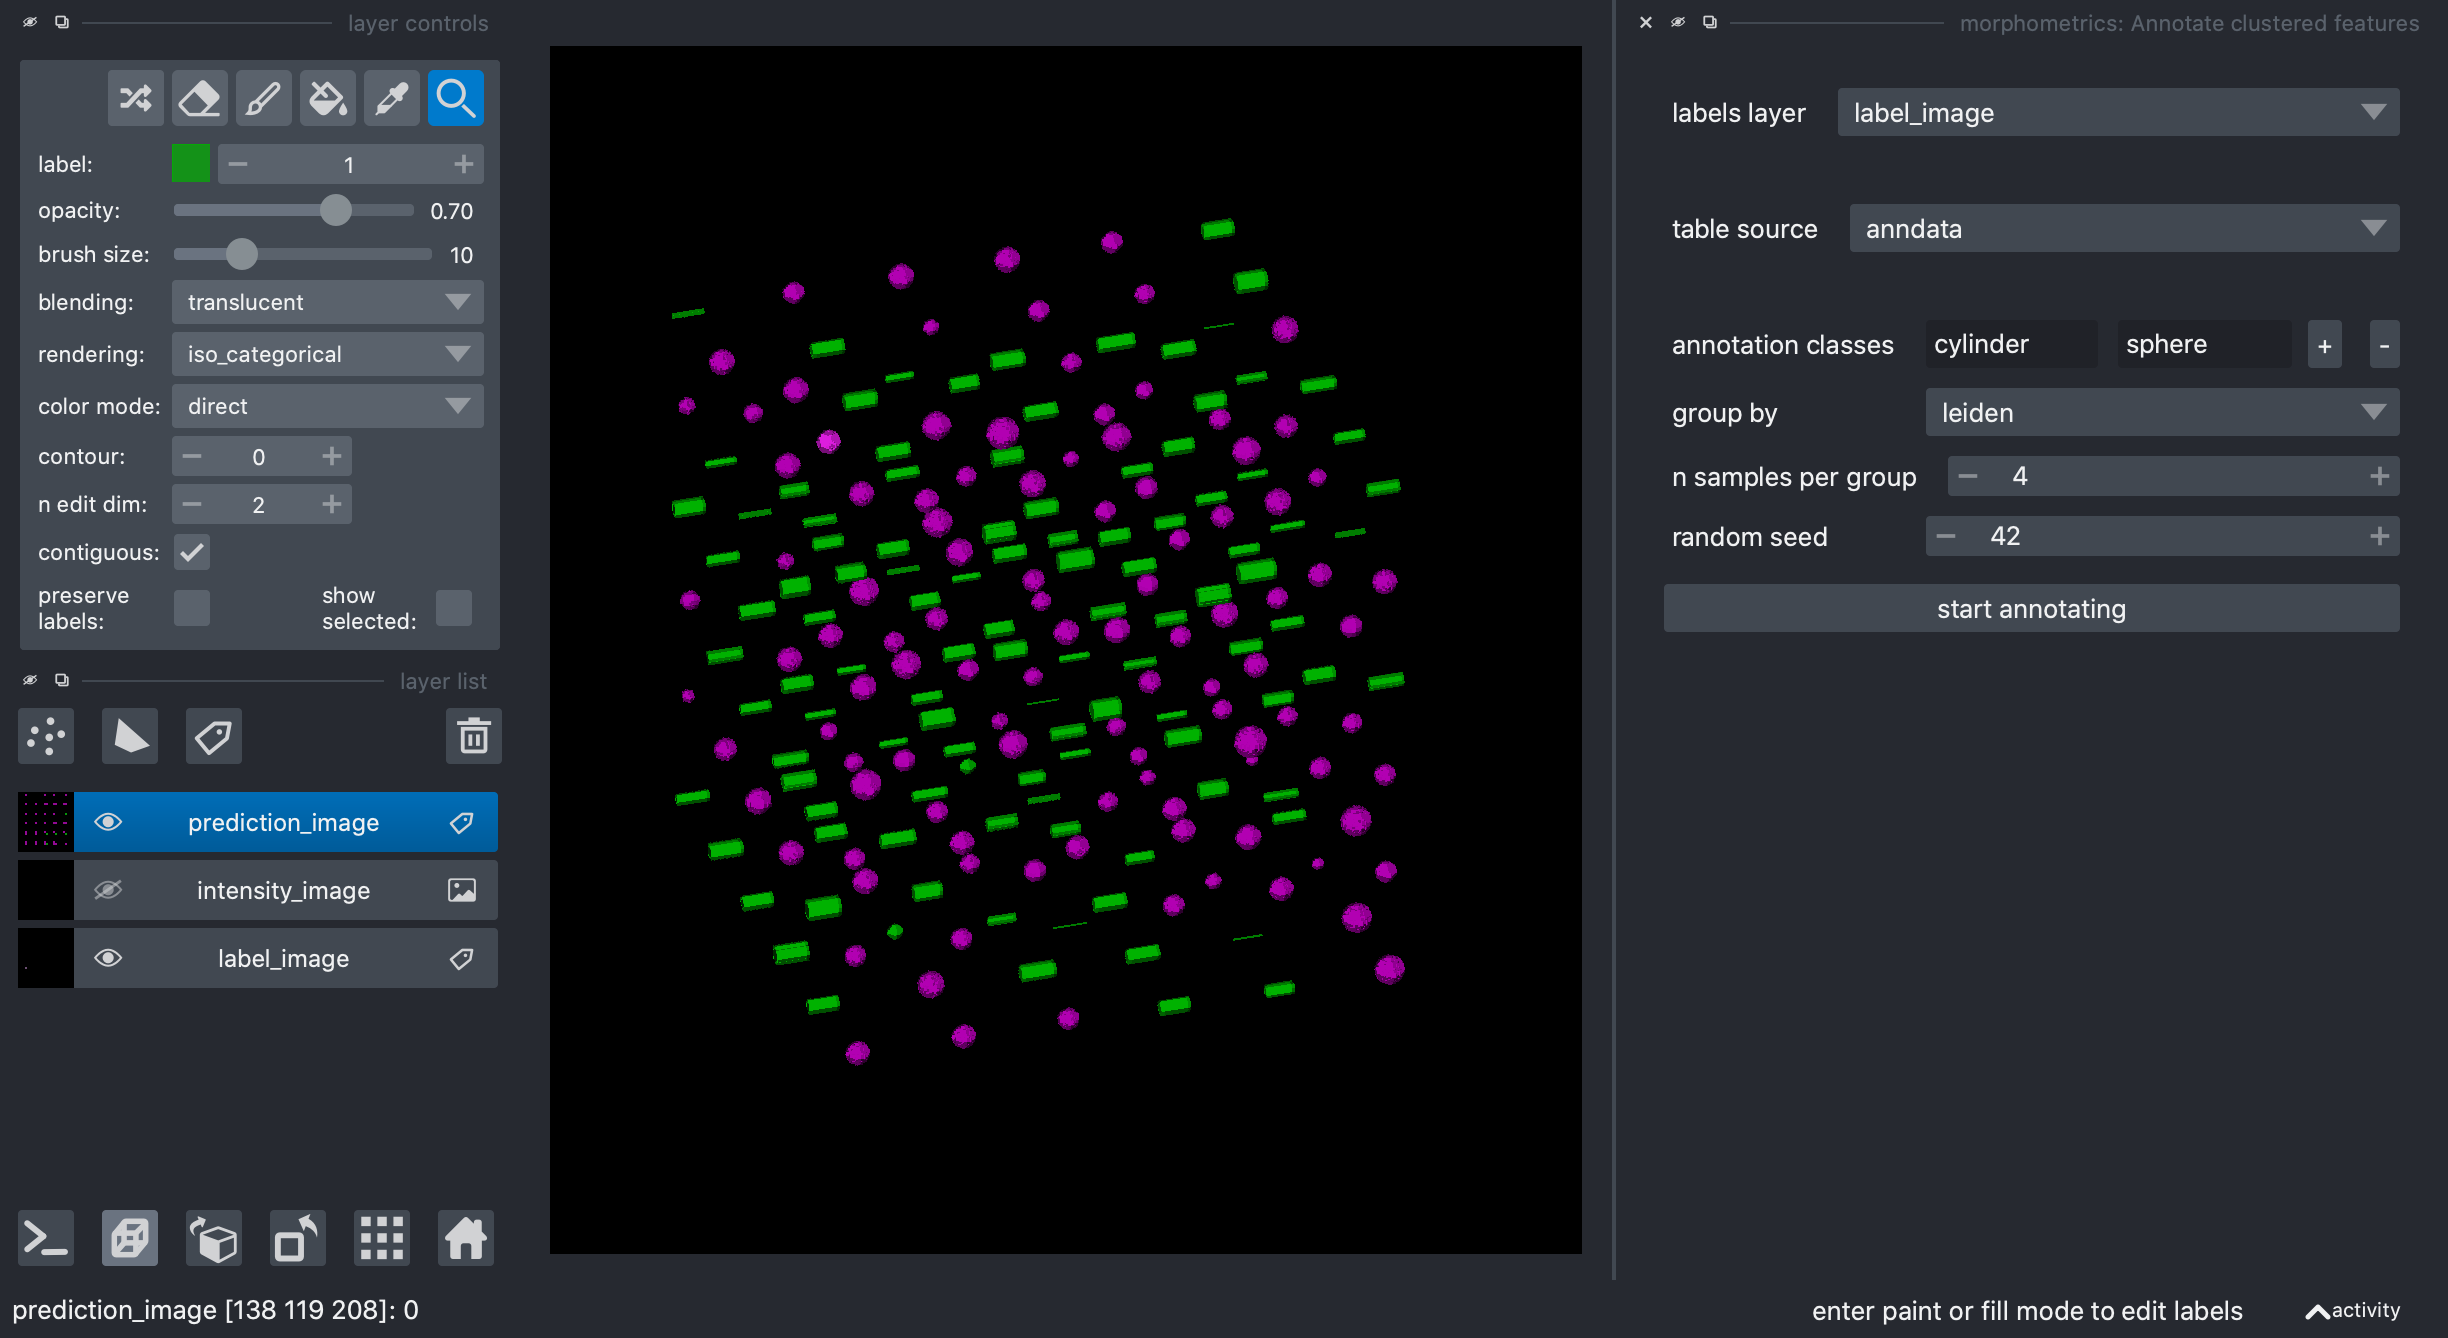

In [27]:
# predicted spheres shown in magenta and cylinders in green!
nbscreenshot(viewer)